## Case Study 2: Chapter 8 – Security-Constrained Optimal Power Flow (SCOPF)

 Authors:   Neeraj Dhanraj Bokde  (www.neerajbokde.in)
            and Carlo Fanara

 Affiliation: Renewable & Sustainable Energy Research Center, TII, Abu Dhabi

 Corresponding author: neeraj.bokde@tii.ae / neerajdhanraj@gmail.com

 Description:
   This script implements the SCOPF case study from Chapter 8
   ("Reliability and Resilience in Power Systems") of The PyPSA Handbook.
   A 5-bus network is modeled and solved under normal conditions using standard
   Optimal Power Flow (OPF). A series of N-1 contingency scenarios are introduced,
   each representing an outage of one transmission line. For each contingency,
   the network is re-optimized to evaluate operational feasibility and resilience.
   The maximum generator dispatch across all scenarios is computed to derive a
   conservative dispatch strategy.

   The results are visualized through comparative dispatch bar plots and
   summarized in terms of cost and unserved energy. This case highlights how
   strict SCOPF constraints shape operational planning and provide insights
   into vulnerability, flexibility, and economic trade-offs under uncertainty.

 Book Reference:
   Bokde, N. D., & Fanara, C. (2025). Reliability and Resilience in Power Systems.
   In: The PyPSA Handbook: Integrated Power System Analysis and Renewable
   Energy Modeling, Chapter 8.
   Publisher: Elsevier Science
   ISBN: 044326631X, 9780443266317

 Software Dependencies:
   - Python 3.8+
   - pypsa (v0.21+ recommended)
   - numpy, pandas, matplotlib

 License: MIT
 
 Version: 1.0
 
 Date: June 2025

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


### 1. Create Base Network

In [2]:
n = pypsa.Network()
n.set_snapshots(pd.date_range("2025-01-01", periods=1, freq="h"))

In [3]:
# Add 5 buses
for i in range(5):
    n.add("Bus", f"Bus {i}", carrier="AC")

In [4]:
# Add generators (wind, gas, CHP, diesel)
n.add("Generator", "G0", bus="Bus 0", p_nom=100, marginal_cost=0, carrier="wind")
n.add("Generator", "G1", bus="Bus 1", p_nom=80, marginal_cost=50, carrier="gas")
n.add("Generator", "G2", bus="Bus 2", p_nom=40, marginal_cost=40, carrier="chp")
n.add("Generator", "G3", bus="Bus 3", p_nom=100, marginal_cost=200, carrier="diesel")

In [5]:
# Add loads
n.add("Load", "Load1", bus="Bus 1", p_set=50)
n.add("Load", "Load2", bus="Bus 2", p_set=30)
n.add("Load", "Load3", bus="Bus 3", p_set=40)
n.add("Load", "Load4", bus="Bus 4", p_set=80)

In [6]:
# Add transmission lines (loop + radial)
line_params = dict(carrier="AC", x=0.1, r=0.01, s_nom=100)
n.add("Line", "Line_0_1", bus0="Bus 0", bus1="Bus 1", **line_params)
n.add("Line", "Line_1_2", bus0="Bus 1", bus1="Bus 2", **line_params)
n.add("Line", "Line_2_3", bus0="Bus 2", bus1="Bus 3", **line_params)
n.add("Line", "Line_3_0", bus0="Bus 3", bus1="Bus 0", **line_params)
n.add("Line", "Line_1_4", bus0="Bus 1", bus1="Bus 4", **line_params)

In [7]:
# Add high-cost unserved generators at each bus
for i in range(5):
    n.add("Generator", f"Unserved_{i}", bus=f"Bus {i}", p_nom=1e4, marginal_cost=10000, carrier="unserved")

### 2. Solve Base OPF & Save to Disk

In [8]:
n.optimize(solver_name="glpk")
ofp_dispatch = n.generators_t.p.copy()
ofp_cost = n.objective
n.export_to_netcdf("base_network.nc")

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.44s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 14 primals, 34 duals
Objective: 4.60e+03
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-o019l2ai.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-fjq1m544.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-o019l2ai.lp'...
34 rows, 14 columns, 51 non-zeros
229 lines were read
GLPK Simplex Optimizer 5.0
34 rows, 14 columns, 51 non-zeros
Preprocessing...
5 rows, 9 columns, 17 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+04  ratio =  1.000e+04
GM: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
EQ: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Constructing initial basis...
Size of triangular part is 5
      0: obj =  -2.113300000e+06 inf =   9.900e+02 (4)
      5: obj =   1.804000000e+06 inf =   0.000e+00 (0)
*    11: obj =   4.600000000e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb (

INFO:pypsa.io:Exported network base_network.nc has buses, loads, generators, lines


<xarray.Dataset>
Dimensions:                       (snapshots: 1, investment_periods: 0,
                                   buses_i: 5, buses_t_p_i: 5,
                                   buses_t_v_ang_i: 5,
                                   buses_t_marginal_price_i: 5, loads_i: 4,
                                   loads_t_p_i: 4, generators_i: 9,
                                   generators_t_p_i: 3,
                                   generators_t_mu_upper_i: 2,
                                   generators_t_mu_lower_i: 6, lines_i: 5,
                                   lines_t_p0_i: 5, lines_t_p1_i: 5)
Coordinates: (12/15)
  * snapshots                     (snapshots) int64 0
  * investment_periods            (investment_periods) object 
  * buses_i                       (buses_i) object 'Bus 0' 'Bus 1' ... 'Bus 4'
  * buses_t_p_i                   (buses_t_p_i) object 'Bus 0' ... 'Bus 4'
  * buses_t_v_ang_i               (buses_t_v_ang_i) object 'Bus 0' ... 'Bus 4'
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 'Bus 0' ....
    ...                            ...
  * generators_t_p_i              (generators_t_p_i) object 'G0' 'G1' 'G2'
  * generators_t_mu_upper_i       (generators_t_mu_upper_i) object 'G0' 'G2'
  * generators_t_mu_lower_i       (generators_t_mu_lower_i) object 'G3' ... '...
  * lines_i                       (lines_i) object 'Line_0_1' ... 'Line_1_4'
  * lines_t_p0_i                  (lines_t_p0_i) object 'Line_0_1' ... 'Line_...
  * lines_t_p1_i                  (lines_t_p1_i) object 'Line_0_1' ... 'Line_...
Data variables: (12/41)
    snapshots_snapshot            (snapshots) datetime64[ns] 2025-01-01
    snapshots_objective           (snapshots) float64 1.0
    snapshots_stores              (snapshots) float64 1.0
    snapshots_generators          (snapshots) float64 1.0
    investment_periods_objective  (investment_periods) object 
    investment_periods_years      (investment_periods) object 
    ...                            ...
    lines_x_pu_eff                (lines_i) float64 0.1 0.1 0.1 0.1 0.1
    lines_r_pu_eff                (lines_i) float64 0.01 0.01 0.01 0.01 0.01
    lines_s_nom_opt               (lines_i) float64 100.0 100.0 ... 100.0 100.0
    lines_v_nom                   (lines_i) float64 1.0 1.0 1.0 1.0 1.0
    lines_t_p0                    (snapshots, lines_t_p0_i) float64 57.5 ... ...
    lines_t_p1                    (snapshots, lines_t_p1_i) float64 -57.5 ......
Attributes:
    network__linearized_uc:  0
    network__multi_invest:   0
    network_name:            
    network_objective:       4600.0
    network_pypsa_version:   0.23.0
    network_srid:            4326
    meta:                    {}

### 3. SCOPF Simulation: Outage each line

In [9]:
contingency_lines = ["Line_0_1", "Line_1_4", "Line_1_2", "Line_2_3", "Line_3_0"]
scopf_dispatches = []
scopf_costs = []
scopf_unserved = []

In [10]:
for line in contingency_lines:
    m = pypsa.Network("base_network.nc")
    m.lines.at[line, "s_nom"] = 0  # outage the line

    for bus in m.buses.index:
        if f"Unserved_{bus}" not in m.generators.index:
            m.add("Generator", f"Unserved_{bus}", bus=bus, p_nom=1e4, marginal_cost=10000, carrier="unserved")

    status = m.optimize(solver_name="glpk")
    if m.objective is None:
        print(f"Infeasible for outage: {line}")
        continue

    scopf_dispatches.append(m.generators_t.p)
    scopf_costs.append(m.objective)
    unserved_sum = m.generators_t.p.filter(like="Unserved").sum(axis=1).values[0]
    scopf_unserved.append(unserved_sum)

INFO:pypsa.io:Imported network base_network.nc has buses, generators, lines, loads
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.4s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 19 primals, 44 duals
Objective: 4.63e+05
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-266r_v3n.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-knx01yy9.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-266r_v3n.lp'...
44 rows, 19 columns, 66 non-zeros
294 lines were read
GLPK Simplex Optimizer 5.0
44 rows, 19 columns, 66 non-zeros
Preprocessing...
6 rows, 13 columns, 20 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+04  ratio =  1.000e+04
GM: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
EQ: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Constructing initial basis...
Size of triangular part is 6
      0: obj =  -1.383000000e+05 inf =   6.900e+02 (4)
      5: obj =   1.461000000e+06 inf =   0.000e+00 (0)
*     7: obj =   4.626000000e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb 

INFO:pypsa.io:Imported network base_network.nc has buses, generators, lines, loads
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.41s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 19 primals, 44 duals
Objective: 8.01e+05
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-efxpobvw.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-5595a760.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-efxpobvw.lp'...
44 rows, 19 columns, 66 non-zeros
294 lines were read
GLPK Simplex Optimizer 5.0
44 rows, 19 columns, 66 non-zeros
Preprocessing...
5 rows, 12 columns, 20 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+04  ratio =  1.000e+04
GM: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
EQ: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Constructing initial basis...
Size of triangular part is 5
      0: obj =  -3.108300000e+06 inf =   9.400e+02 (3)
      5: obj =   1.020000000e+06 inf =   0.000e+00 (0)
*    11: obj =   8.008000000e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb 

INFO:pypsa.io:Imported network base_network.nc has buses, generators, lines, loads
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.41s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 19 primals, 44 duals
Objective: 4.77e+03
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-je4elf8u.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-e_h2ap0u.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-je4elf8u.lp'...
44 rows, 19 columns, 66 non-zeros
294 lines were read
GLPK Simplex Optimizer 5.0
44 rows, 19 columns, 66 non-zeros
Preprocessing...
6 rows, 13 columns, 20 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+04  ratio =  1.000e+04
GM: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
EQ: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Constructing initial basis...
Size of triangular part is 6
      0: obj =  -1.132300000e+06 inf =   7.100e+02 (4)
      6: obj =   1.356600000e+06 inf =   0.000e+00 (0)
*    10: obj =   4.766666667e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb 

INFO:pypsa.io:Imported network base_network.nc has buses, generators, lines, loads
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.42s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 19 primals, 44 duals
Objective: 5.10e+03
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-0lzkshf8.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-yzbyeflf.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-0lzkshf8.lp'...
44 rows, 19 columns, 66 non-zeros
294 lines were read
GLPK Simplex Optimizer 5.0
44 rows, 19 columns, 66 non-zeros
Preprocessing...
6 rows, 13 columns, 20 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+04  ratio =  1.000e+04
GM: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
EQ: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Constructing initial basis...
Size of triangular part is 6
      0: obj =  -1.149300000e+06 inf =   6.800e+02 (5)
      6: obj =   1.755000000e+06 inf =   0.000e+00 (0)
*    11: obj =   5.100000000e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb 

INFO:pypsa.io:Imported network base_network.nc has buses, generators, lines, loads
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.4s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 19 primals, 44 duals
Objective: 1.56e+04
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-bzsl8t9f.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-971qwvh0.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-bzsl8t9f.lp'...
44 rows, 19 columns, 66 non-zeros
294 lines were read
GLPK Simplex Optimizer 5.0
44 rows, 19 columns, 66 non-zeros
Preprocessing...
6 rows, 13 columns, 20 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+04  ratio =  1.000e+04
GM: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
EQ: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Constructing initial basis...
Size of triangular part is 6
      0: obj =   7.787000000e+05 inf =   7.000e+02 (5)
      6: obj =   1.461000000e+06 inf =   0.000e+00 (0)
*     9: obj =   1.560000000e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb 

In [11]:
# Conservative dispatch: max output needed across all feasible SCOPF cases
scopf_dispatch = pd.concat(scopf_dispatches).groupby(level=0).max() if scopf_dispatches else ofp_dispatch.copy()

### 4. Plot OPF vs. SCOPF Dispatch

In [12]:
ofp_dispatch["type"] = "Base OPF"
scopf_dispatch["type"] = "Strict SCOPF"
ofp_dispatch.columns = ofp_dispatch.columns.astype(str)
scopf_dispatch.columns = scopf_dispatch.columns.astype(str)

In [13]:
dispatch_all = pd.concat([ofp_dispatch, scopf_dispatch])
dispatch_all = dispatch_all.reset_index().melt(id_vars=["snapshot", "type"], 
                                               var_name="Generator", 
                                               value_name="Dispatch")

In [14]:
plt.figure(figsize=(7, 4.5))
generators = ["G0", "G1", "G2", "G3"]
colors = {"Base OPF": "#4575b4", "Strict SCOPF": "#d73027"}
hatch = {"Base OPF": "//", "Strict SCOPF": ""}

<Figure size 700x450 with 0 Axes>

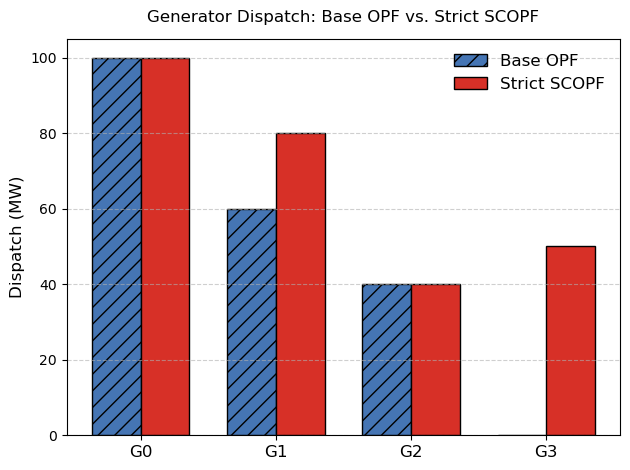

In [15]:
for i, gen in enumerate(generators):
    for j, mode in enumerate(["Base OPF", "Strict SCOPF"]):
        val = dispatch_all[(dispatch_all["Generator"] == gen) & (dispatch_all["type"] == mode)]["Dispatch"].values[0]
        offset = -0.18 if mode == "Base OPF" else 0.18
        plt.bar(i + offset, val, width=0.36, 
                color=colors[mode], 
                hatch=hatch[mode], 
                edgecolor="k", 
                label=mode if i == 0 else None)

plt.xticks(range(len(generators)), generators, fontsize=12)
plt.ylabel("Dispatch (MW)", fontsize=12)
plt.title("Generator Dispatch: Base OPF vs. Strict SCOPF", fontsize=12, pad=12)
plt.legend(fontsize=12, frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 5. Print Summary Stats

In [16]:

print("Base OPF cost:", round(ofp_cost, 2))
print("Average SCOPF contingency cost:", round(np.mean(scopf_costs), 2))
print("Worst-case SCOPF contingency cost:", round(np.max(scopf_costs), 2))
print("Average unserved energy (MW) in SCOPF cases:", round(np.mean(scopf_unserved), 2))
print("Max unserved energy (MW) in SCOPF cases:", round(np.max(scopf_unserved), 2))

Base OPF cost: 4600.0
Average SCOPF contingency cost: 257773.33
Worst-case SCOPF contingency cost: 800800.0
Average unserved energy (MW) in SCOPF cases: 25.0
Max unserved energy (MW) in SCOPF cases: 80.0



### End of Security-Constrained Optimal Power Flow (SCOPF) Case Study (Chapter 8)
